In [1]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
import re


In [2]:
try:
    with open("short_story.txt", 'r', encoding="utf-8") as f:
        data = f.read()
except FileNotFoundError:
    print("File not found")
    data = "default fallback short story"

data = re.sub(r'[^a-zA-Z\s]', '', data.lower())

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in data.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram = token_list[:i+1]
        input_sequences.append(n_gram)

max_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='pre')
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
ys = to_categorical(labels, num_classes=total_words)

In [4]:
def build_model(cell_type='RNN'):
    input_layer = Input(shape=(max_len - 1,))
    x = Embedding(total_words, 50)(input_layer)

    if cell_type == 'RNN':
        x = SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2)(x)
    elif cell_type == 'LSTM':
        x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x)
    elif cell_type == 'GRU':
        x = GRU(128, dropout=0.2, recurrent_dropout=0.2)(x)

    output_layer = Dense(total_words, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


In [5]:
def train(model):
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(xs, ys, epochs=100, validation_split=0.1, callbacks=[es])
    return history


In [6]:
rnn_model = build_model('RNN')
lstm_model = build_model('LSTM')
gru_model = build_model('GRU')

In [7]:
history_rnn = train(rnn_model)
history_lstm = train(lstm_model)
history_gru = train(gru_model)


Epoch 1/100
9/9 [==============================] - 4s 85ms/step - loss: 5.3266 - accuracy: 0.0075 - val_loss: 5.3432 - val_accuracy: 0.0333
Epoch 2/100
9/9 [==============================] - 0s 30ms/step - loss: 5.3006 - accuracy: 0.0263 - val_loss: 5.3442 - val_accuracy: 0.1333
Epoch 3/100
9/9 [==============================] - 0s 30ms/step - loss: 5.2302 - accuracy: 0.0752 - val_loss: 5.4467 - val_accuracy: 0.1333
Epoch 4/100
9/9 [==============================] - 0s 32ms/step - loss: 5.1011 - accuracy: 0.0940 - val_loss: 5.6878 - val_accuracy: 0.1333
Epoch 5/100
9/9 [==============================] - 0s 29ms/step - loss: 5.0198 - accuracy: 0.0902 - val_loss: 5.8327 - val_accuracy: 0.1333
Epoch 6/100
9/9 [==============================] - 0s 28ms/step - loss: 5.0043 - accuracy: 0.0902 - val_loss: 5.8668 - val_accuracy: 0.1333
Epoch 7/100
9/9 [==============================] - 0s 28ms/step - loss: 4.9758 - accuracy: 0.0902 - val_loss: 5.8870 - val_accuracy: 0.1333
Epoch 8/100
9/9 [===

In [8]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-10) / temperature  # prevent log(0)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def predict_next_words(model, seed_text, next_words=5, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)[0]
        next_index = sample(predicted, temperature)
        next_word = tokenizer.index_word.get(next_index, '')
        seed_text += ' ' + next_word
    return seed_text

print("RNN Prediction:", predict_next_words(rnn_model, "arin reached", 5, temperature=0.9))
print("LSTM Prediction:", predict_next_words(lstm_model, "arin reached", 5, temperature=0.9))
print("GRU Prediction:", predict_next_words(gru_model, "arin reached", 5, temperature=0.9))

print("RNN Accuracy:", rnn_model.evaluate(xs, ys, verbose=0)[1])
print("LSTM Accuracy:", lstm_model.evaluate(xs, ys, verbose=0)[1])
print("GRU Accuracy:", gru_model.evaluate(xs, ys, verbose=0)[1])


RNN Prediction: arin reached felt feeling just see as
LSTM Prediction: arin reached map beside stones trembled heart
GRU Prediction: arin reached steps here boots trouble echoed
RNN Accuracy: 0.07770270109176636
LSTM Accuracy: 0.09459459781646729
GRU Accuracy: 0.09459459781646729


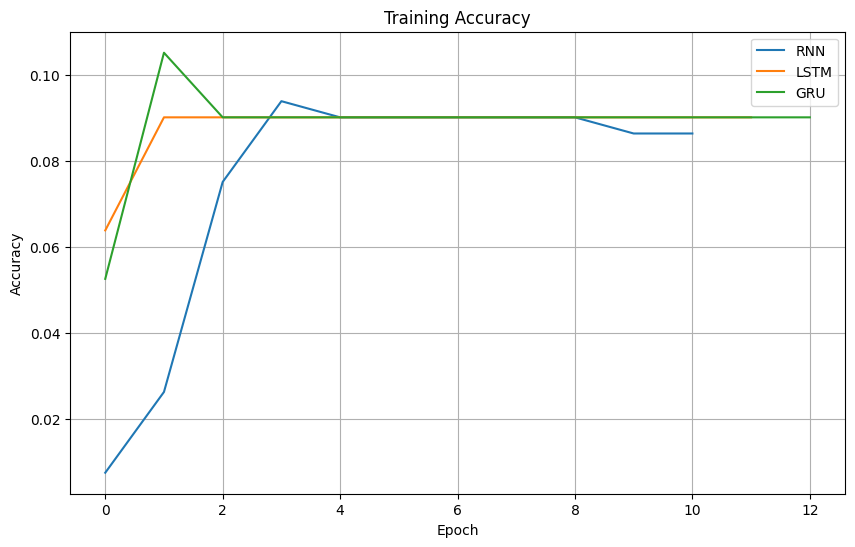

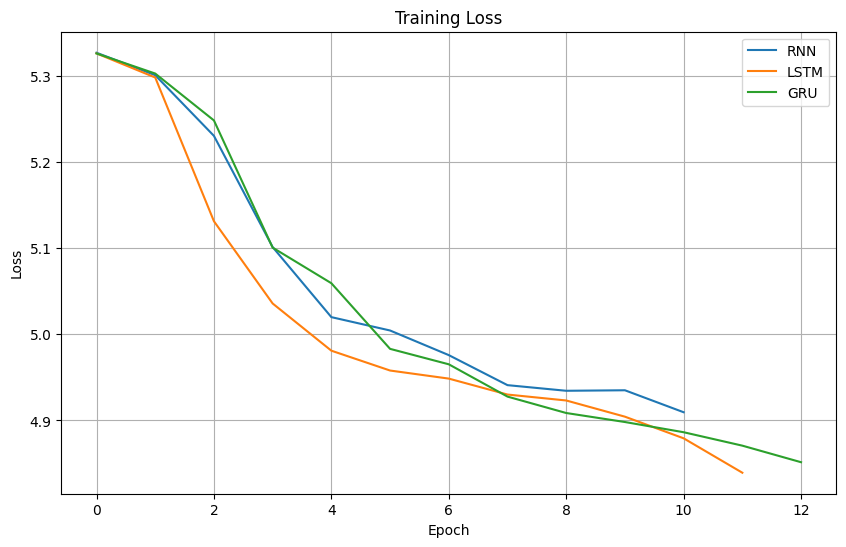

In [9]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['accuracy'], label='RNN')
plt.plot(history_lstm.history['accuracy'], label='LSTM')
plt.plot(history_gru.history['accuracy'], label='GRU')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['loss'], label='RNN')
plt.plot(history_lstm.history['loss'], label='LSTM')
plt.plot(history_gru.history['loss'], label='GRU')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()